In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [12]:
mpl.rcdefaults()
plt.style.use(["../stylesheet.mplstyle"])
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
def calculate_distribution_functions(values, num_bins):
    count, bins = np.histogram(values, bins=num_bins)
    width = bins[1] - bins[0]
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    return bins[1:], pdf / width, cdf

In [4]:
def get_data(pathname):
    df = pd.read_csv(f"../../data-export/{pathname}/recalibration-factors.csv")
    normalized_residuals = np.genfromtxt(f"../../data-export/{pathname}/normalized-residuals.csv", delimiter=',')
    return df, normalized_residuals

In [5]:
def plot_figure(
    df_recalibration_factors,
    normalized_residuals,
    ax0,
    ax1,
    show_legend=True,
    title=None,
    num_bins=50
):    
    x = [float(p) for p in df_recalibration_factors.columns[1:]]
    all_factors = df_recalibration_factors.to_numpy()
    global_factors = all_factors[:, 0]
    local_factors = all_factors[:, 1:]
    num_trials = len(global_factors)
    y = np.mean(local_factors, axis=0)
    yerr = np.std(local_factors, axis=0, ddof=1) / np.sqrt(num_trials)
    global_avg = np.mean(global_factors)
    global_stderr = np.std(global_factors, ddof=1) / np.sqrt(num_trials)
    
    x_resid, pdf_resid, cdf_resid = calculate_distribution_functions(normalized_residuals / np.std(normalized_residuals), num_bins)
    x_ref, pdf_ref, cdf_ref = calculate_distribution_functions(np.random.normal(size=300000), num_bins)

    ax0.plot(x_resid, pdf_resid, color=colors[0], label="normalized residuals")
    ax0.plot(x_ref, pdf_ref, linestyle='--', color=colors[1], label="normal distribution")
    ax0.set_xlabel("x")
    ax0.set_yticks([])
    ax0.set_xlim([-5.5, 5.5])
    ax0.set_ylabel("pdf")
    if show_legend:
        ax0.legend(loc='upper left')
    if title is not None:
        ax0.set_title(title)
    axR = ax0.twinx()
    axR.plot(x_resid, cdf_resid, color=colors[3])
    axR.plot(x_ref, cdf_ref, linestyle='--', color=colors[2])
    axR.set_yticks([])
    axR.set_ylabel("cdf")

    ax1.errorbar(x, y, yerr=yerr, color=colors[3], label="bootstrap recalibration factor")
    ax1.hlines(global_avg, x[0], x[-1], colors=colors[0], label="MLE recalibration factor")
    ax1.hlines(
        [global_avg - global_stderr, global_avg + global_stderr], x[0], x[-1],
        linestyle = '--',
        colors=colors[0]
    )
    ax1.set_xlabel("Confidence Level")
    ax1.set_ylabel("Recalibration Factor")
    if show_legend:
        ax1.legend()

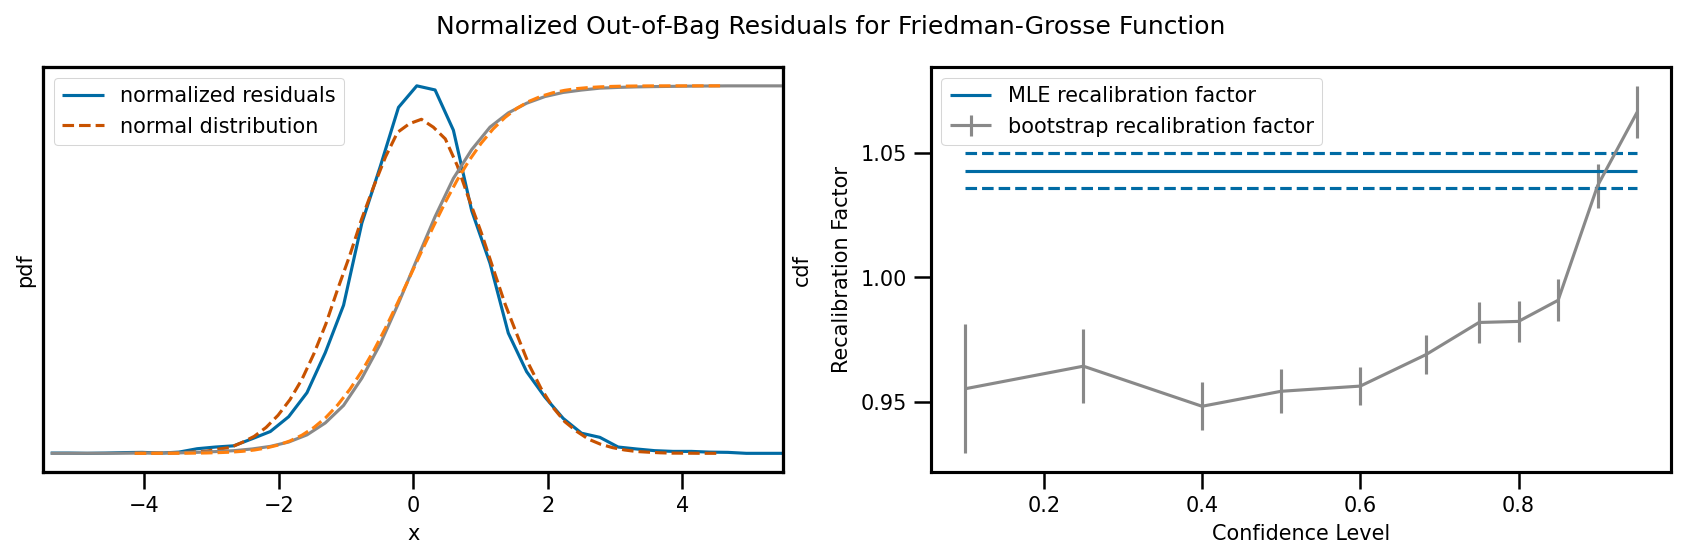

In [13]:
df, normalized_residuals = get_data("Friedman-Grosse-noise-2")
fig, axs = plt.subplots(1, 2, figsize=(14, 3.5))
plot_figure(df, normalized_residuals, axs[0], axs[1])
plt.suptitle("Normalized Out-of-Bag Residuals for Friedman-Grosse Function")
axs[1].set_yticks([0.95, 1.0, 1.05])
axs[0].tick_params(length=8)
axs[1].tick_params(length=8)
plt.savefig("fig1.svg")

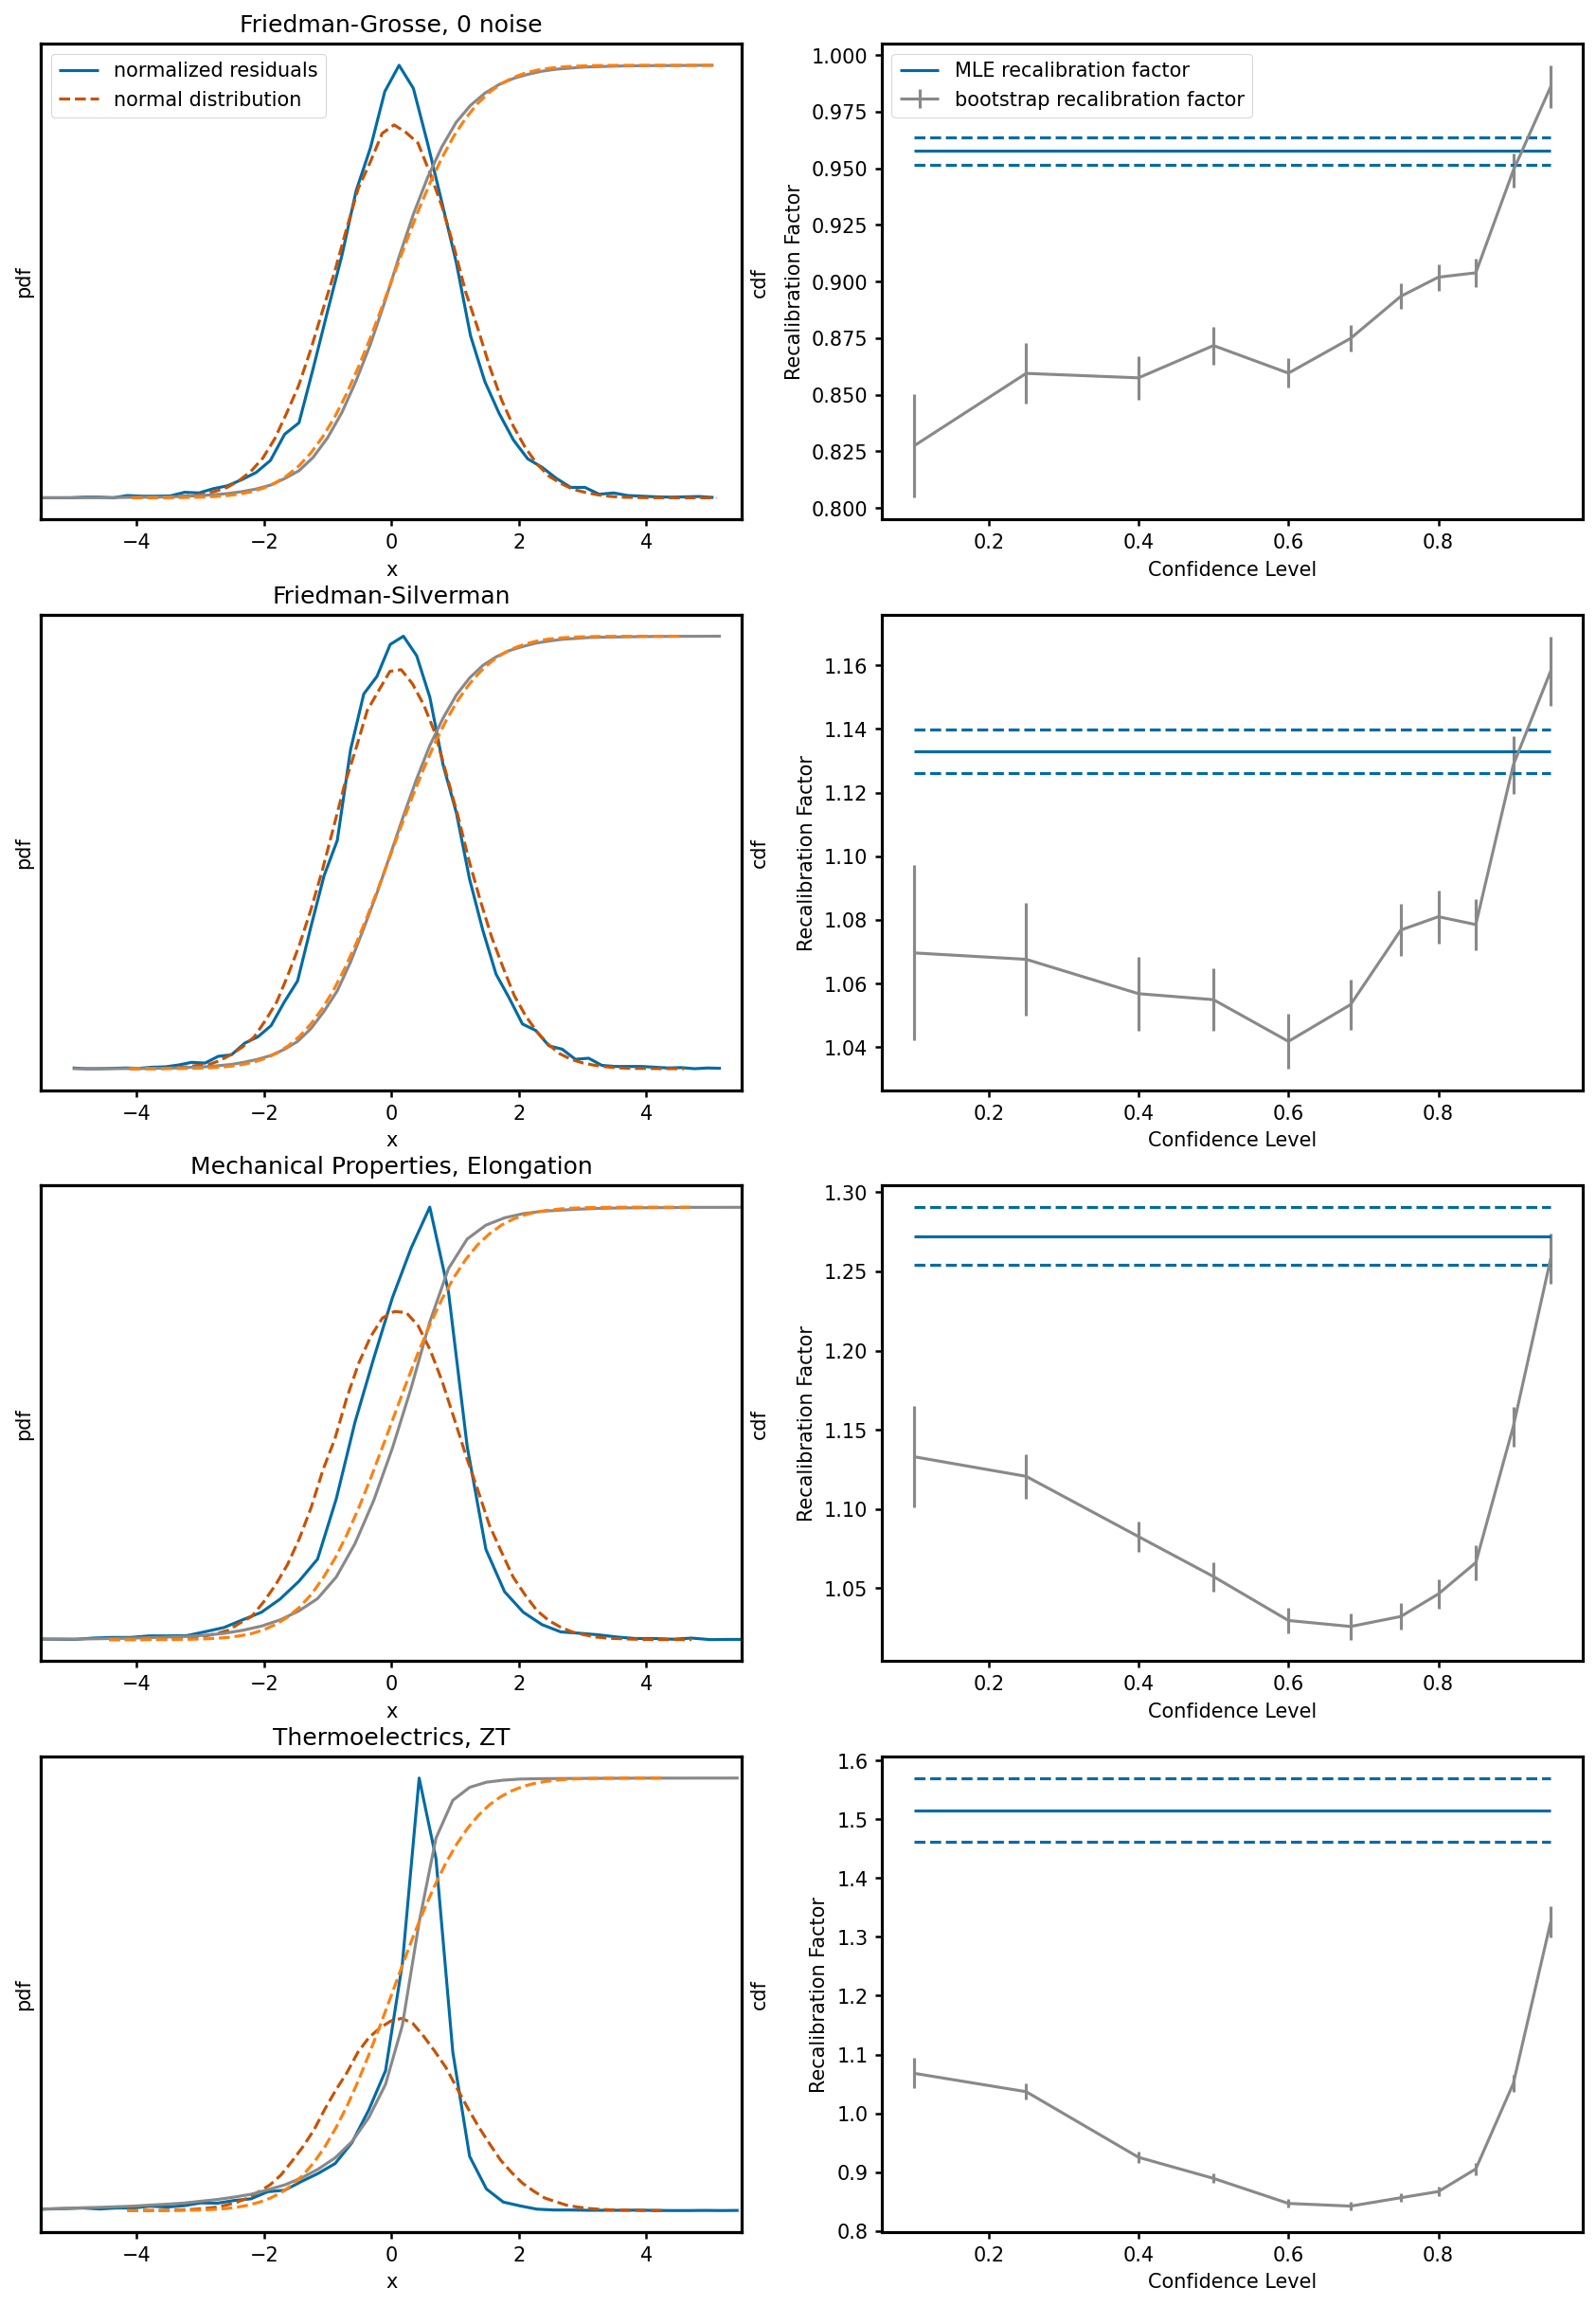

In [14]:
fig, axs = plt.subplots(4, 2, figsize=(14, 20))
df_FG0, residuals_FG0 = get_data("Friedman-Grosse-noise-0")
plot_figure(df_FG0, residuals_FG0, axs[0, 0], axs[0, 1], title="Friedman-Grosse, 0 noise")
df_FS, residuals_FS = get_data("Friedman-Silverman-noise-2")
plot_figure(df_FS, residuals_FS, axs[1, 0], axs[1, 1], show_legend=False, title="Friedman-Silverman")
df_mech, residuals_mech = get_data("mechanical-properties-elongation")
plot_figure(df_mech, residuals_mech, axs[2, 0], axs[2, 1], show_legend=False, title="Mechanical Properties, Elongation")
df_therm, residuals_therm = get_data("thermoelectrics-zt")
plot_figure(df_therm, residuals_therm, axs[3, 0], axs[3, 1], show_legend=False, title="Thermoelectrics, ZT")
plt.savefig("supplementary.svg")